In [1]:
scale = 0.08
W = int(1920*scale)
H = int(1080*scale)

In [2]:
print(W)
print(H)

153
86


In [3]:
from moviepy.editor import VideoFileClip
import cv2
import numpy as np

# Load the video
video_path = 'data/y2mate.is - Topdown water moving to up left-g2P2ni2yN4o-1080pp-1711844452.mp4'
video = VideoFileClip(video_path)

# Parameters for frame extraction
fps = video.fps  # Frames per second
duration = video.duration  # Duration in seconds to extract frames from
n_frames = int(fps * duration)  # Total frames to extract based on duration

# Function to process frames: convert to grayscale and resize
def process_frame(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frame_resized = cv2.resize(frame_gray, (W, H))  # Resize to reduce computation
    return frame_resized

# Extract and process frames
processed_frames = []
for i in range(n_frames):
    frame = video.get_frame(i/fps)
    processed_frame = process_frame(frame)
    processed_frames.append(processed_frame)

# Convert to a numpy array for further processing
processed_frames_array = np.array(processed_frames)

# Display the shape of the processed frames array to verify
processed_frames_array.shape


(711, 86, 153)

In [4]:
processed_frames_array.shape[0]

711

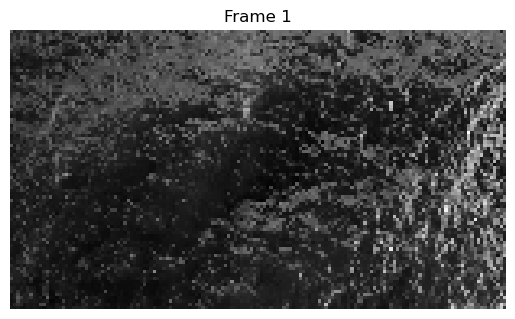

In [5]:
import matplotlib.pyplot as plt

# Assuming processed_frames_array is your array of processed video frames
# Display the first frame
plt.imshow(processed_frames_array[0], cmap='gray')
plt.title('Frame 1')
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

In [6]:
# Assuming shape (frames, H, W)
# Flatten each frame
flattened_frames = processed_frames_array.reshape(processed_frames_array.shape[0], -1)
# Now flattened_frames should have the shape (frames, HW), ready to be fed into the model
# Normalization
flattened_frames = flattened_frames / 255.0

flattened_frames.shape

(711, 13158)

In [7]:
# Calculate the indices for each split
train_end = int(n_frames * 0.6)
validate_end = train_end + int(n_frames * 0.2)
A = train_end
B = validate_end-train_end
print('A = train_end = ', A)
print('B = validate_end = ', B)

# Split the data
train_data = flattened_frames[:train_end]
validate_data = flattened_frames[train_end:validate_end]
test_data = flattened_frames[validate_end:]

# Check the shape of each set
print("Training Data Shape:", train_data.shape)
print("Validation Data Shape:", validate_data.shape)
print("Testing Data Shape:", test_data.shape)

A = train_end =  426
B = validate_end =  142
Training Data Shape: (426, 13158)
Validation Data Shape: (142, 13158)
Testing Data Shape: (143, 13158)


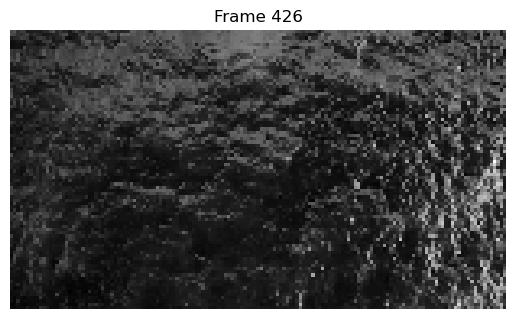

In [8]:
plt.imshow(processed_frames_array[A-1], cmap='gray')
plt.title('Frame '+str(A))
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

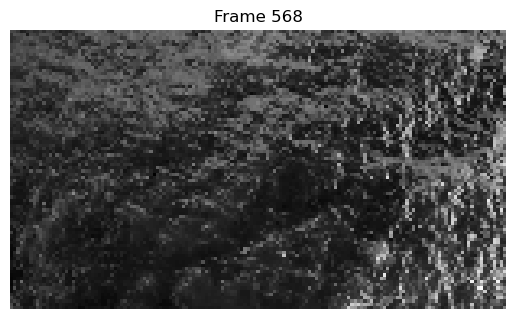

In [9]:
plt.imshow(processed_frames_array[A+B-1], cmap='gray')
plt.title('Frame '+str(A+B))
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

In [10]:
import torch
torch.cuda.empty_cache()
np.random.seed(42)

In [11]:
from fourier_koopman import koopman, fully_connected_mse
# Initialize the Koopman object with a fully connected MSE model
# x_dim should match the dimension of your flattened frames
# num_freqs is a hyperparameter that you might need to adjust based on your data
k = koopman(fully_connected_mse(x_dim=H*W, num_freqs=40, n=2**6), device='cuda')

k.set_sample_num_based_on_data(train_data, p = 0.20)  # Use the same data portion intended for fitting

# Fit the model on a portion of the video frames, e.g., first A frames
train_losses = k.fit(train_data, iterations=1000, interval=50, verbose=True)

sample_num set to: 85
Setting  0 to 1645.8636363636363
Setting  1 to 114.58544303797468
Setting  2 to 41.33447488584475
Setting  3 to 10345.42857142857
Setting  4 to 36209.0
Setting  5 to 43.41606714628297
Setting  6 to 24139.333333333332
Setting  7 to 18104.5
Setting  8 to 1609.2888888888888
Setting  9 to 32.66486242670275
Setting  10 to 40.18756936736958
Setting  11 to 42.39929742388758
Setting  12 to 14483.6
Setting  13 to 44.428220858895706
Setting  14 to 12069.666666666666
Setting  15 to 39.18722943722943
Setting  16 to 9052.25
Setting  17 to 1080.865671641791
Setting  18 to 447.0246913580247
Setting  19 to 1448.3600000000001
Setting  20 to 528.5985401459855
Setting  21 to 8046.444444444444
Setting  22 to 1114.123076923077
Setting  23 to 5172.714285714285
Setting  24 to 7241.8
Setting  25 to 1392.653846153846
Setting  26 to 717.0099009900989
Setting  27 to 1168.032258064516
Setting  28 to 1574.304347826087
Setting  29 to 928.4358974358975
Setting  30 to 1034.542857142857
Setting  

In [12]:
len(train_losses)

1000

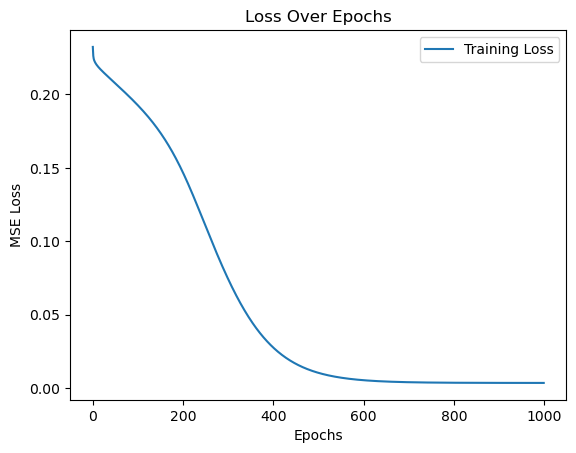

In [13]:
# Plotting training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

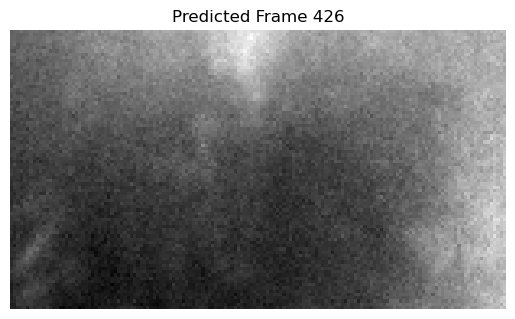

In [14]:
xhat_koopman = k.predict(A-1)

# Inverse normalization
xhat_koopman = xhat_koopman * 255.0
first_predicted_frame = xhat_koopman[0].reshape(H, W)
plt.imshow(first_predicted_frame, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title('Predicted Frame '+str(A))
plt.axis('off')  # Hide axes for better visualization
plt.show()

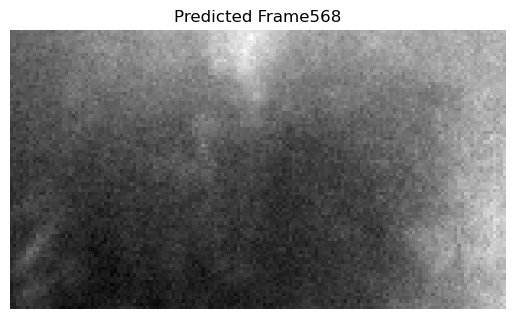

In [15]:
# Predict the next frames, e.g., predicting the next B frames
xhat_koopman = k.predict(A+B-1)

# Inverse normalization
xhat_koopman = xhat_koopman * 255.0
# xhat_koopan contains the predicted frames from A to A+B, reshaped back to their original dimension
first_predicted_frame = xhat_koopman[0].reshape(H, W)
# Display the first predicted frame
plt.imshow(first_predicted_frame, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title('Predicted Frame'+str(A+B))
plt.axis('off')  # Hide axes for better visualization
plt.show()

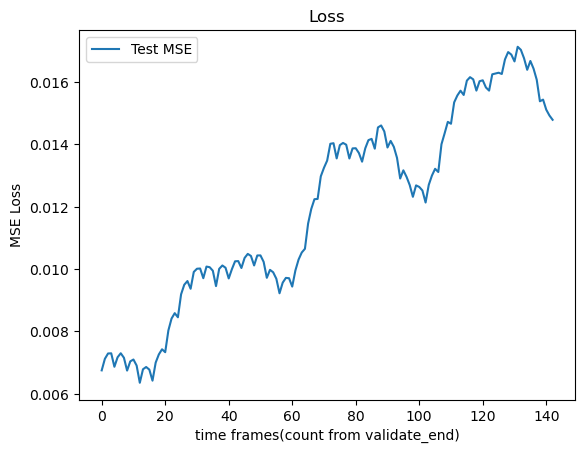

In [16]:
#Test Metrics
xhat_koopman = k.predict(n_frames) 
#should be in shape (frames, HW)
test_mse = np.mean((xhat_koopman[validate_end:]-test_data)**2, axis=1)

# Plotting loss
plt.plot(test_mse, label='Test MSE')
plt.xlabel('time frames(count from validate_end)')
plt.ylabel('MSE Loss')
plt.title('Loss')
plt.legend()
plt.show()

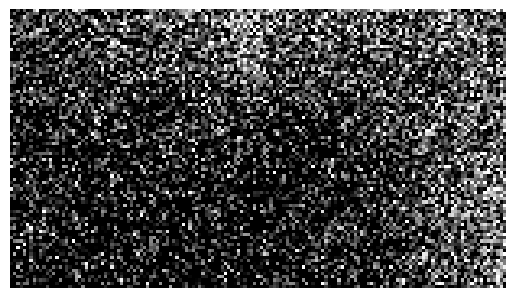

In [17]:
from matplotlib.animation import FuncAnimation

# Function to update the plot with the next predicted frame
def update_frame(i, frames, plot):
    plot.set_data(frames[i])
    return plot,

# Reshape all predicted frames back to their original 2D shape
xhat_koopman = xhat_koopman * 255.0
predicted_frames_2d = xhat_koopman.reshape(-1, H, W)

fig, ax = plt.subplots()
plot = plt.imshow(predicted_frames_2d[0], cmap='gray', animated=True)
plt.axis('off')

ani = FuncAnimation(fig, update_frame, frames=len(predicted_frames_2d), fargs=(predicted_frames_2d, plot), blit=True, interval=fps)
ani.save('animation_xhat_koopman.mp4')
plt.show()
